In [442]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  6 20:16:49 2018

@author: Ryan Hockstad
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

   The following functions are used to scrape the data in this notebook from Basketball-reference.com.  

In [50]:
def get_soup(url):    
    html = str(urlopen('https://www.basketball-reference.com' + url).read())
    html = re.sub("<!--|-->","", html)
    return bs(html, 'lxml')

def get_header(tbl):
    pass


def get_data(soup, tableNumber = 0):
    t = soup.find_all('table')[tableNumber]
    df = pd.read_html(str(t), flavor = 'bs4')[0]
    regexp = re.compile(r'^Unnamed')
    cols = [c for c in df.columns if not regexp.search(c)]
    return df[cols]

In [70]:
mvpListUrl = '/leagues/'
soup = get_soup(mvpListUrl)
rows = soup.find('table').findAll('tr')[2::]

   The first thing I wanted to do was find some information on the stats of MVPs.  I had heard that after he won the MVP last season, James Harden had more free throws than field goals made in his career. The initial reason for this notebook was to see if this was true for any other MVP, and if there are any other weird stats to find. 

In [157]:
data = []
for row in rows:
    league = row.find('td').get_text()
    mvp = row.findAll('td')[2].get_text()
    if not(league == 'NBA' and mvp):
        continue
    
    season = row.find('th').get_text()
    url = row.findAll('td')[2].find('a')['href']
    soup = get_soup(url)
    
    mvpData = get_data(soup, 1)
    mvpData.set_index('Season', inplace = True)
    mvpData['CFG'] = mvpData.FG.cumsum()
    mvpData['CFT'] = mvpData.FT.cumsum()

    newRow = {'Player':mvp}
    newRow['CFG'] = mvpData.CFG[season]
    newRow['CFT'] = mvpData.CFT[season]
    newRow['Year'] = season[:4]
    newRow['Position'] = mvpData.Pos[season]
    newRow['MinutesPlayed'] = mvpData.MP[season]
    newRow['Assists'] = mvpData.AST[season]
    newRow['FieldGoals'] = mvpData.FG[season]
    newRow['FieldGoalPercent'] = mvpData['FG%'][season]
    newRow['Rebounds'] = mvpData.TRB[season]
    newRow['PTS'] = mvpData.PTS[season]
    newRow['FreeThrows'] = mvpData.FT[season]
    newRow['FreeThrowPercent'] = mvpData['FT%'][season]
    
    data.append(newRow)


In [158]:
df = pd.DataFrame(data)
df['FG/FT Difference'] = df.CFG - df.CFT
df.Year = pd.to_datetime(df.Year)
df.set_index('Year', inplace = True)
df.sort_index(inplace = True)

   Since I have gathered so much data on MVPs, why not try to see if there is anything interesting to look at?  First, I'll make some graphs to see trends involving stats vs time.

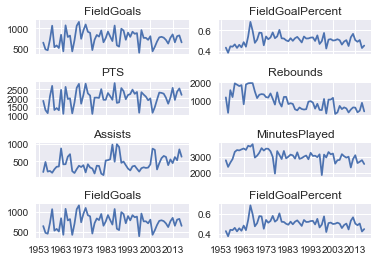

In [93]:
stats = ['FieldGoals', 'FieldGoalPercent', 'PTS', 'Rebounds', 'Assists', 'MinutesPlayed', 'FieldGoals', 'FieldGoalPercent']

fig, ax = plt.subplots(4, 2, sharex='col')
fig.subplots_adjust(hspace=.8)
for i, axi in enumerate(ax.flat):
    axi.plot(df.index, df[stats[i]])
    axi.set(title = stats[i])

   It doesn't look like the stats of the MVP have changed very significantly since the award was introduced in 1955.  There are  a few outliers over the years, but I would have thought that there would be some trends like increased scoring, particularly with the introduction of the 3 pointer in 1979.  I'll look into that later.  

   There are two trends that seem to be apparent:  Rebounds have gone down, and assists have gone up.  Perhaps that is because the position that won the MVP has changed over the years.  

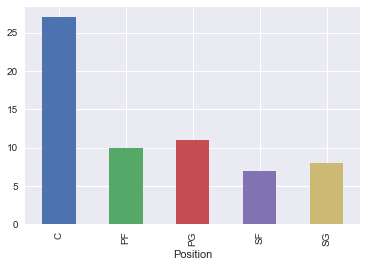

In [90]:
#First, I'll see how ofteneach posiition wons the MVP
df.groupby(df.Position).size().plot(kind = 'bar')

In [185]:
#Now, I'll see when each position has won the MVP.
df['Year'] = df.index.year.values
df.groupby(df.Position).Year.mean()

Position
C     1972.111111
PF    1995.100000
PG    1995.090909
SF    1998.571429
SG    1998.000000
Name: Year, dtype: float64

   It seems that Centers have won by far the most, and they won a lot a long time ago compared to other positions.  The rest of the positions pretty equal.  Lets see who has the most MVPs:

In [187]:
p = df.groupby(df.Player).size().sort_values(ascending = False).index[:5]
mask = [player in p for player in df.Player]
df.loc[mask][['Player', 'Position']]

,Player,Position
Year,,
1957-01-01,B. Russell,C
1959-01-01,W. Chamberlain,C
1960-01-01,B. Russell,C
1961-01-01,B. Russell,C
1962-01-01,B. Russell,C
1964-01-01,B. Russell,C
1965-01-01,W. Chamberlain,C
1966-01-01,W. Chamberlain,C
1967-01-01,W. Chamberlain,C


   The fact that three players who played the center position have won the MVP 15 times seems to be the reason why the previous graph seems to have the MVP evenly distributed across all positions except center.  Remove these three players from the data, and it becomes much more even.

   These three players also won the award very frequently between 1955 and 1980.  Since centers tend to get more rebounds and fewer assists than other positions, this could explain why the trends for these two categories exist.

   Lets see if I can help support this with some stats.  I can test the following two hypotheses:  MVP centers get more rebounds than other MVP positions, and they get fewer assists.

In [190]:
from scipy import stats
center = [p == 'C' for p in df.Position]
notCenter = [not i for i in center]

centerAssists = df.loc[center].Assists.values
notCenterAssists = df.loc[notCenter].Assists.values

centerRebounds = df.loc[center].Rebounds.values
notCenterRebounds = df.loc[notCenter].Rebounds.values

ATStat, assistsPVal = stats.ttest_ind(centerAssists, notCenterAssists, equal_var = False)
RTStat, reboundsPVal = stats.ttest_ind(centerRebounds, notCenterRebounds, equal_var = False)

print(assistsPVal, reboundsPVal)

5.252295635639612e-06 8.34581440895706e-12


   So the p values show that it is extremely unlikely that a typical MVP winning Center would be expected to get a rebound or assist as another player.  

   The differences in stats by position gives me an interesting idea.  Maybe if I took data from every player from last year, I would be able to tell what position he played simply by looking at his stats.

In [366]:
#This uses the functions I declared earlier to get the data from the internet.
i = 2000
url = '/leagues/NBA_' + str(i) + '_per_game.html'
soup = get_soup(url)
df = get_data(soup)
while i < 2018:
    i = i + 1
    url = '/leagues/NBA_' + str(i) + '_per_game.html'
    soup = get_soup(url)
    df = pd.concat([df, get_data(soup)])

   The following cell cleans the data so it will be usable with some sklearn algorithms.  I also only chose to use players who had at least 15 minutes played per game.  This is because I think that players who don't get much playing time won't have good enough stats to have a positive impact on an ML Algorithm.

   It also appears that a very small number of players have hybrid positions.  I will drop these players from my data.

   Finally, I have normalized the data by dividing every stat by the total minutes played.

In [367]:
df.MP = pd.to_numeric(df.MP, errors = 'coerce')
df.dropna(inplace = True)
df = df[df.MP>=30]              #This gets rid of players who don't play a lot of minutes
df = df[df.Pos.apply(len) < 3]  #This gets rid of the hybrid players

y = df.Pos
X = df[['MP', '3P', 'FGA', 'FT', 'FTA', 'AST', 'STL', 'BLK', 'TOV', '2PA']]
X = X.apply(pd.to_numeric, errors = 'Coerce')
X = X.divide(X.MP, axis = 0)

#I need to encode the y values to numbers in order to use ML algorithms to predict them.
#I also need to separate my data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y)
enc = LabelEncoder()
y_enc = enc.fit_transform(y_train)

   Now comes the fun part.  I will use a support vector machine to see if I can guess which position a player has 

In [445]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel = 'rbf', class_weight = 'balanced')
params = {'C': [10**5, 5*10**5, 10**6, 3*10**6],
          'gamma': [800/len(X)]}
grid = GridSearchCV(svc, params)

%time grid.fit(X_train, y_enc)

print(grid.best_score_)
print(grid.best_params_)

Wall time: 2min 23s
0.6248391248391248
{'gamma': 0.3861003861003861, 'C': 100000}


0.3861003861003861

   This support vector classifier is correct about 60% of the time.  That isn't too shabby, considering that random guesses would be correct about 1/5 of the time.
    
   To improve this, I could consider adding more data points. I could also probably use different features, normalize them, or use a different model.  

   Perhaps, though, some positions are just very difficult to tell the difference by just lookign at the player's stats.  I will make a heat map of the test set to check if this is the case:

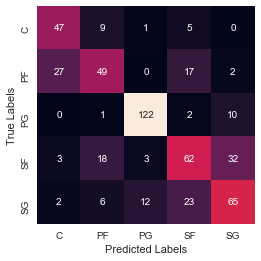

In [455]:
y_pred = grid.predict(X_test)
y_pred = enc.inverse_transform(y_pred)

from sklearn.metrics import confusion_matrix

labels = ['C', 'PF', 'PG', 'SF', 'SG']

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = labels, yticklabels = labels)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels');

   It appears that there seems to be the most confusion between (Centers and Power Forwards), (Power Forwards and Small Forwards), and (Small Forwards and Shooting Guards).  
    
   This makes sense, because those positions overlap a little.  Point guards seem to be easily identified by this algorithm, perhaps because they get a lot of assists.
    
   I could probably improve this classifier by looking at other algorithms or creating some learning or validation curves.  I might add to this later.